In [1]:
import json
import operator
import numpy as np
import pandas as pd
import networkx as nx
import collections,sys,math 
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
# Load data
data = json.load(open('../data/raw/tweet.json'))

# Utils.py

In [3]:
def get_user_attr(id_, dictionary_tweet, tweet, attr, user = True):
    """the function return the attr of the tweet and put it in the dictionary related to the tweet
    @tweet_id: id 
    @dictionary_to_update: dictionary (key,value):(tweet_id, (key,value):(attr,value))
    @tweet: who tweet"""
    
    if user:
         dictionary_tweet[id_][attr] = tweet['user'][attr]
    else:
        dictionary_tweet[id_][attr] = tweet[attr]
        
    return dictionary_tweet

In [4]:
def FindHashHags(tweet):
    """
    This function takes the twittersearch output tweet,
    cleans up the text and the format, and returns
    the set of all hashtags in the tweet
    """
    # First get the tweet text
    tweettxt = str(tweet.encode('ascii','ignore'))
    
    # Add spacing before the hashtag symbol
    tweettxt = tweettxt.replace('#',' #')
    
    # Clean all punctuation 
    for punct in '\.!",;:%<>/~@`()[]{}?-':
        tweettxt = tweettxt.replace(punct,' ')
    
    # Split the tweet 
    tweettxt = tweettxt.split()
    
    # List of hashtags
    hashtags = []
    # Loop over the words in the tweet
    for word in tweettxt:
        # Find words beginning with hashtag
        if word[0]=='#':

            hashtag = word.lower()
            # Correct for possisives
            hashtag= hashtag.split('\'')[0]         
            
            # Get rid of the hashtag symbol
            hashtag = hashtag.replace('#','')
            # Check existence of word after #
            if len(hashtag)>0:
                hashtags.append(hashtag)
    
    return hashtags

### Create dictionary of tweets that gathers also information about user 

In [5]:
dictionary_tweet = {}
list_attr_user = ['description','favourites_count','followers_count','friends_count','location','screen_name']
list_attr = ['text', 'retweeted']

for t in data:
    id_ = t['id']
    dictionary_tweet[id_] = {}
    
    # Extract attribute related to the tweet
    for attr in list_attr:
        dictionary_tweet = get_user_attr(id_, dictionary_tweet, t, attr, user = False)
    
    # Get info of the user 
    for attr in list_attr_user:
        dictionary_tweet = get_user_attr(id_, dictionary_tweet, t, attr)

In [6]:
print ("We collected: ", len(dictionary_tweet), " including retweets.")

We collected:  4395  including retweets.


### Get the list of hashtags found in the collection of tweets

In [7]:
list_hashtags = []

# Dizionari che definisce per ogni tweet la lista degli hashtag
hashtags_dict = defaultdict(list)

# For each tweet
for id_ in dictionary_tweet:
    # Define the list of hashtags
    list_h = FindHashHags(dictionary_tweet[id_]['text'])
    hashtags_dict[id_] += list_h
    list_hashtags += list_h
    
# List of hashtags
non_set = list_hashtags
# Set of hashtags
list_hashtags = list(set(list_hashtags))

In [8]:
print ("Il numero di hashtag, non unici, contenuti nei tweet è", len(non_set), '.')
print ("Il numero di hashtag unici è: ", len(list_hashtags), '.')

Il numero di hashtag, non unici, contenuti nei tweet è 9190 .
Il numero di hashtag unici è:  1104 .


### Study the hashtag frequency to choose the hashtags to include in the analysis

Idealmente, vogliamo effettuare la nostra analisi su hashtag significativi. Pertanto decidiamo un threshold euristico.

In [9]:
count_hashtags = defaultdict(int)
for i in non_set:
    count_hashtags[i] += 1

In particolare osserviamo che la media e la mediana della collezione di tweet differiscono significativamente. Nello specifico la media è circa 9 volte più alta della mediana che, al contrario, indica che almeno il 50% degli hashtag compare solo una volta nei tweet di interesse.


* Si decide di considerare gli hashtag la cui frequenza è maggiore di 5 e il cui numero di caratteri è superiore a 1.

In [10]:
revome_one_hash = {i:j for i,j in count_hashtags.items() if j > 5 and len(i)>1}
list_hashtags = list(revome_one_hash.keys())

Quindi vediamo quanti sono gli hashtag identificati come significativi per l'identificazione degli argomenti. 

In [11]:
print ("Numero di hashtag significativi: ", len(list_hashtags), '.')

Numero di hashtag significativi:  157 .


### Definire nuovamente il dizionario tweet>lista di hashtag in accordo con gli hashtag rimasti

In [12]:
hashtags_dict = {i: [k for k in j if k in list_hashtags] for i,j in hashtags_dict.items()}

* Definisci, per ogni hashtag, la lista di tweet che lo contiene

In [13]:
dict_hashtag = defaultdict(list)
#list_id_toscana = []
for tag in list_hashtags:
    for i, l in hashtags_dict.items():
        if tag in l:
            dict_hashtag[tag] += [i]

* Per ogni hashtag ottieni la lista degli hashtag con cui co-occorre.

In [14]:
dict_list_hashtag = defaultdict(list)
#list_id_toscana = []
for tag in list_hashtags:
    for i, l in hashtags_dict.items():
        if tag in l:
            dict_list_hashtag[tag] += [j for j in l if j!=tag and j in list_hashtags]

### Identificare i retweet e rimuoverli (questa sezione verrà modificata molto probabilmente)

In [15]:
list_tweet = list(dictionary_tweet.keys())
# List of tweet contents
list_text_tweets = [(idx,dictionary_tweet[idx]['text']) for idx in list_tweet]

# 
df_tweets = pd.DataFrame(list_text_tweets, columns=['ID', 'TEXT'])
df_tweets.head()

,ID,TEXT
0,970993648392220672,Qualità dell'#aria: i dati rilevati il #5marzo...
1,970993502669692928,RT @Laura_Rocci: #Toscana\nIl @Mov5Stelle piaz...
2,970993070480199681,Bollettino Meteo https://t.co/SLPL8bu3NL 2018-...
3,970989949993603072,RT @LetsCleanUpEU: #fishingforlitter in #Tosca...
4,970989844267786240,RT @Laura_Rocci: #Toscana\nIl @Mov5Stelle piaz...


In [16]:
# Remove http elements in text
df_tweets['mod_TEXT'] = df_tweets['TEXT'].apply(lambda x: ' '.join([i for i in x.split(' ') if not i.startswith('http')]))

# Get rid of duplicates
df_tweets.drop_duplicates(['mod_TEXT'], keep = 'first', inplace=True)

# Remove the RT from text
df_tweets['mod_RT'] = df_tweets['mod_TEXT'].apply(lambda x: ' '.join(x.split(':')[1:]).strip() if x.startswith('RT') else ' '.join(x.split(':')).strip())

# Get rid of duplicates
df_tweets.drop_duplicates(['mod_RT'], keep = 'first', inplace=True)

print ("Il numero finale dei tweet da analizzare è: ", len(df_tweets), '.')

Il numero finale dei tweet da analizzare è:  2016 .


## Operazione di clustering per trovare gli argomenti

__Goal:__

Find groups of tweets that belongs to the same topic (allowing that a tweet corresponds to more than one cluster).

* Topic: set of hashtags - we make this assumption since has been shown that they are good proxy of topics.
* We build the graph of hashtags that are connected when they co-occur in a tweet.
* Apply the PCA.
* Run a hierarchical clustering algorithm.
* Then we associate tweets to the clusters.

In [17]:
# Edges of the graph - co-occurences
tuples_hash = []
for i,l in dict_list_hashtag.items():
    for h,times in collections.Counter(l).items():
        tuples_hash += [(i,h, times)]

# PROVA a togliere l'occorrenza

In [18]:
tuples_hash = [(i,j) for i,j,k in tuples_hash]# if k != 1]

In [19]:
# Con Jaccard
# La presenza di zeri dipende dall'operazione nella cella [31]. Da correggere
tuples_weights = []
for h_1, h_2 in tuples_hash:
    inter = len(set(dict_list_hashtag[h_1]).intersection(dict_list_hashtag[h_2]))
    unio = len(set(dict_list_hashtag[h_1]).union(dict_list_hashtag[h_2]))
    jacc_distance = 1-(inter/unio)
    tuples_weights += [(h_1,h_2,jacc_distance)]
    #tuples_weights += [(h_1,h_2,inter)]

### Create graph of hashtags

In [20]:
G = nx.Graph()
G.add_weighted_edges_from(tuples_weights)
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 157
Number of edges: 670
Average degree:   8.5350


In [21]:
# Assign id
id_hash = {i:j for i,j in enumerate(list_hashtags)}
hash_id = {j:i for i,j in id_hash.items()}

### Get the adjecency matrix

In [22]:
adjacency_matrix = nx.to_numpy_matrix(G)

In [23]:
import numpy as np
from sklearn.decomposition import PCA
X = adjacency_matrix
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0, 30)

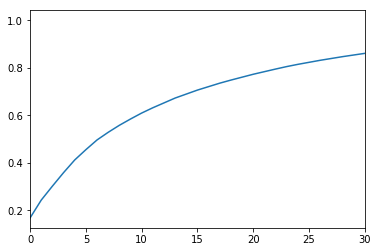

In [24]:
variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(variance))
plt.xlim((0,30))

### Choose the number of components and apply the dimensionality reduction

In [25]:
X = adjacency_matrix
pca = PCA(n_components=30,svd_solver = 'arpack' )
pca.fit(X) 

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

In [26]:
dimensionality_reduction = pca.fit_transform(X)

## Hierarchical clustering

* __Linkage__: Ward
* __Metric__: Euclidean

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [28]:
np.set_printoptions(precision=5, suppress=True)
Z = linkage(dimensionality_reduction, 'ward', metric = 'euclidean')

In [53]:
Z

array([[ 76.     ,  77.     ,   0.     ,   2.     ],
       [123.     , 132.     ,   0.     ,   2.     ],
       [ 56.     ,  92.     ,   0.     ,   2.     ],
       [122.     , 136.     ,   0.     ,   2.     ],
       [ 66.     ,  69.     ,   0.     ,   2.     ],
       [ 49.     ,  51.     ,   0.     ,   2.     ],
       [ 81.     ,  93.     ,   0.     ,   2.     ],
       [158.     , 160.     ,   0.     ,   4.     ],
       [131.     , 139.     ,   0.     ,   2.     ],
       [150.     , 153.     ,   0.     ,   2.     ],
       [ 68.     , 157.     ,   0.     ,   3.     ],
       [ 50.     , 162.     ,   0.     ,   3.     ],
       [100.     , 101.     ,   0.     ,   2.     ],
       [117.     , 118.     ,   0.     ,   2.     ],
       [142.     , 143.     ,   0.     ,   2.     ],
       [ 86.     ,  87.     ,   0.     ,   2.     ],
       [152.     , 166.     ,   0.     ,   3.     ],
       [ 62.     ,  88.     ,   0.     ,   2.     ],
       [ 83.     , 163.     ,   0.     ,   3. 

In [54]:
Z[0,0]

76.0

In [55]:
Z[0,1]

77.0

In [29]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

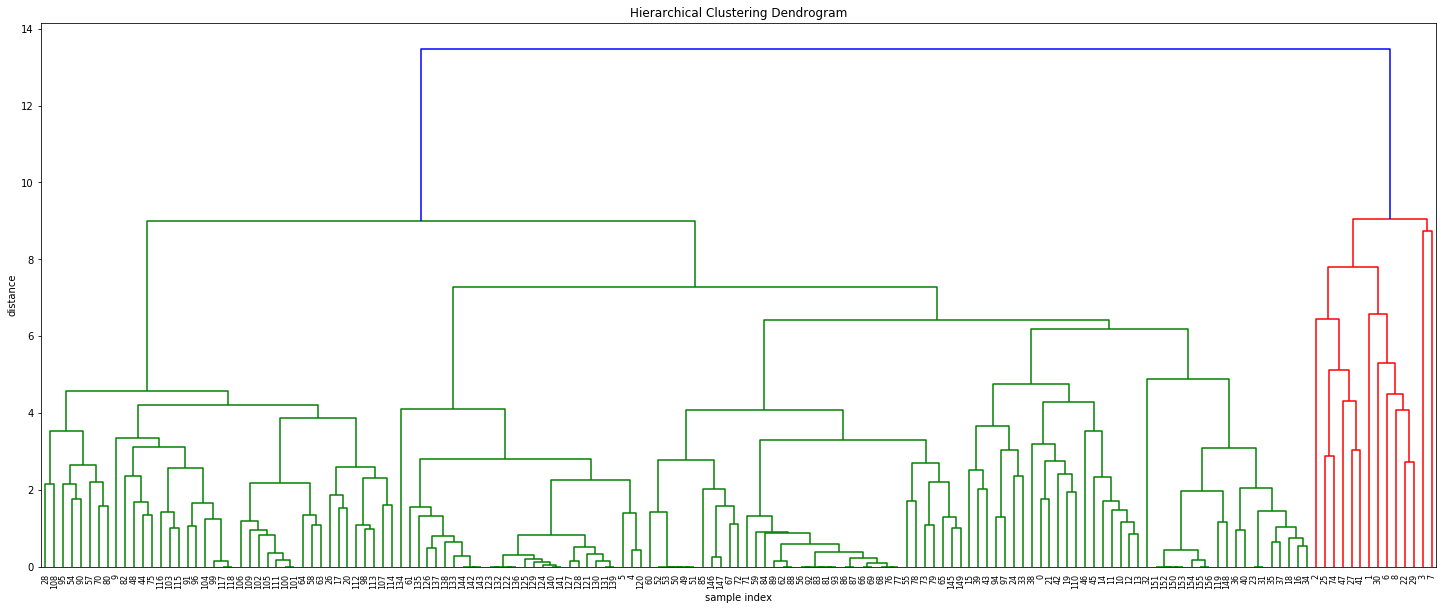

In [30]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

([<matplotlib.axis.XTick at 0x1a1eb78e10>,
 <a list of 8 Text xticklabel objects>)

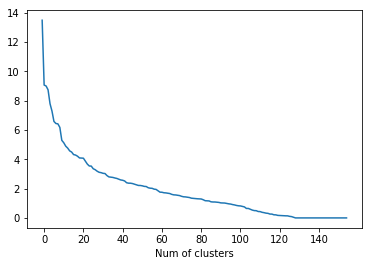

In [31]:
plt.plot(sorted(Z[:,2], reverse =True))
plt.xlabel('Num of clusters')
plt.xticks(range(1,160, 20),range(0,200, 20))

# Prova a creare dataset per visualizzazione bubble

In [58]:
from sklearn.cluster import AgglomerativeClustering
Hclustering = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage="ward")
Hclustering.fit(dimensionality_reduction)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func=<function mean at 0x10904b598>)

In [59]:
prova = Hclustering.fit_predict(dimensionality_reduction)

### Clusters

In [60]:
classes = list(zip(G.nodes(),prova))
h_class = {i:j for i,j in classes}

In [61]:
# For each cluster: the list of hashtags in it
di_clas = defaultdict(list)
for i,j in classes:
    di_clas[j] += [i]

In [62]:
# For each cluster: the number of hashtags
di = defaultdict(int)
for i in prova:
    di[i] += 1

### Smistare i tweet nei cluster

Per ogni tweet si calcola la proporzione di hashtag appartenenti alle classi individuate. Quindi, il tweet appartiene alla classe cui la maggior parte dei sui tweet appartiene. Nello specifico, nel caaso in cui ci sia una stessa proporzione per tutti i cluster, allora il tweet apparterrà a tutte e tre le classi.

In [63]:
# Assign the tweets to clusters
tweets_in_class = defaultdict(list)
for c in di.keys():
    for i in di_clas[c]:
        tweets_in_class[c] += dict_hashtag[i]
        
set_tweets_class = {c: list(set(l)) for c,l in tweets_in_class.items()}
    

In [64]:
# Per ogni classe il set degli hashtag trovati nei tweet
list_hash_class = defaultdict(list)

for c, l_t in set_tweets_class.items():
    for t in l_t:
        list_hash_class[c] += hashtags_dict[t]
        
set_hash_class = {i:list(set(j)) for i,j in list_hash_class.items()}

* Per ogni tweet, calcolare la proporzione di hashtag in ogni classe

In [65]:
dict_tweet_prop_class = {}
for tweet in list_tweet:
    
    list_hash_tweet = hashtags_dict[tweet]
    if len(list_hash_tweet)==0:
        continue
    
    dict_tweet_prop_class[tweet] = {}
    for c in di.keys():
        proportion_hashtag = len(set(list_hash_tweet).intersection(set(di_clas[c])))/len(set(list_hash_tweet))
        if proportion_hashtag != 0: 
            dict_tweet_prop_class[tweet][c] = proportion_hashtag

* Assegnare tweet a classe

In [66]:
tweet_belongs_to = {}

for tweet, clas in dict_tweet_prop_class.items():
    
    if tweet in df_tweets['ID'].unique():
        if len(set(list(clas.values()))) > 1:
            tweet_belongs_to[tweet] = [max(clas.items(), key=operator.itemgetter(1))[0]]

        elif len(set(list(clas.values()))) == 1:
            tweet_belongs_to[tweet] = list(clas.keys())

In [67]:
# To each class associate the list of tweets
class_of_tweets = defaultdict(list)
for tweet, c in tweet_belongs_to.items():
    for el in c:
        class_of_tweets[el] += [tweet]

In [42]:
for i,j in class_of_tweets.items():
    print (i,len(set(j)))

8 129
15 96
4 139
14 83
7 69
17 418
6 87
16 70
2 154
19 289
0 114
1 157
5 97
10 50
3 125
9 73
18 49
11 271
13 102
12 129


# Primo file di output

Per ogni topi rappresento la top 10 di hashtag e il numero di tweet corrispondenti

In [43]:
output = []
for cluster, list_hash in di_clas.items():
    dictionary = {}
    dictionary['topic'] = int(cluster)
    dict_ha = {i: count_hashtags[i] for i in list_hash}
    dictionary['hashtags'] = [(i,count_hashtags[i]) for i in sorted(dict_ha, key=dict_ha.get, reverse=True)]
    dictionary['number_tweets'] = len(set(class_of_tweets[cluster]))
    
    output += [dictionary]

In [44]:
with open('../data/output/topic_squares.json', 'w') as fp:
    json.dump(output, fp)

# Secondo file output

In [45]:
output_2 = []
for cluster, list_hash in di_clas.items():
    dictionary = {}
    dictionary['topic'] = int(cluster)
    dictionary['list_tweets'] = class_of_tweets[cluster]
    output_2 += [dictionary]

In [46]:
with open('../data/output/tweet_list.json', 'w') as fp:
    json.dump(output_2, fp)

## Creare file per la visualizzazione dei topic

In [75]:
output_3 = []
for cluster, list_hash in di_clas.items():
    dictionary = {}
    dictionary['topic'] = int(cluster)
    dict_ha = {i: count_hashtags[i] for i in list_hash}
    dictionary['hashtags'] = [(i,len(dict_hashtag[i])) for i in sorted(dict_ha, key=dict_ha.get, reverse=True)]
    dictionary['number_tweets'] = len(set(class_of_tweets[cluster]))
    
    output_3 += [dictionary]

In [76]:
output_3

[{'hashtags': [('news', 142),
   ('5marzo', 18),
   ('italia', 18),
   ('elezionipolitiche', 9),
   ('pistoia', 7),
   ('senato', 7)],
  'number_tweets': 129,
  'topic': 8},
 {'hashtags': [('toscana', 148)], 'number_tweets': 96, 'topic': 15},
 {'hashtags': [('elezioni2018', 879)], 'number_tweets': 418, 'topic': 17},
 {'hashtags': [('firenze', 988)], 'number_tweets': 289, 'topic': 19},
 {'hashtags': [('nardella', 153),
   ('idydiene', 70),
   ('risorse', 62),
   ('papediaw', 48),
   ('fiorentina', 30),
   ('razzismo', 27),
   ('africa', 24),
   ('ordine', 22),
   ('caos', 22),
   ('senegalesi', 19),
   ('ultimora', 18),
   ('palermo', 17),
   ('senegalese', 17),
   ('senegal', 17),
   ('5febbraio', 13),
   ('somalia', 13),
   ('iosonoantifascista', 13),
   ('immigrazion', 13),
   ('astori', 12),
   ('fioriere', 11),
   ('omicidio', 9),
   ('presidio', 9),
   ('pirrone', 9),
   ('polizia', 7),
   ('davideastori', 6),
   ('solidali', 6),
   ('sindaco', 6),
   ('id', 6)],
  'number_tweets'

In [106]:
lista_dizionari = []

for j in range(len(output_3)):
    dict_topic_cluster = {}
    dict_topic_cluster['name'] = output_3[j]['topic']
    lista_topic = []
    for idx in range(len(output_3[j]['hashtags'])):
        if idx == 0:
            dict_topic_cluster['name'] = output_3[j]['hashtags'][idx][0]
            if len(output_3[j]['hashtags']) == 1:
                lista_topic += [{'name':output_3[j]['hashtags'][idx][0], 'size':output_3[j]['hashtags'][idx][1]}]
            
        else: 
            lista_topic += [{'name':output_3[j]['hashtags'][idx][0], 'size':output_3[j]['hashtags'][idx][1]}]
        
    dict_topic_cluster['children'] = lista_topic[:10]
    
    lista_dizionari += [dict_topic_cluster]

In [107]:
dict_cluster_topic = {'name':'toscana', 'children':lista_dizionari}

In [123]:
print (dict_cluster_topic['children'][0]['name'])
# Distringui tra name e children
dict_cluster_topic['children'][19]

news


{'children': [{'name': 'nonabbiamoarmiinstore', 'size': 87},
  {'name': 'torino', 'size': 38},
  {'name': 'cortona', 'size': 30},
  {'name': 'pontedera', 'size': 29},
  {'name': 'poggibonsi', 'size': 29},
  {'name': 'castiglionfiorentino', 'size': 29},
  {'name': 'vigilidelfuoco', 'size': 29},
  {'name': 'chianciano', 'size': 27},
  {'name': 'comunista', 'size': 25},
  {'name': 'antifascisti', 'size': 20}],
 'name': 'primoposto'}

In [124]:
with open('../data/output/bubble_input.json', 'w') as fp:
    json.dump(dict_cluster_topic, fp)